In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid

In [2]:
# Uploaded stock price csv
from google.colab import files
uploaded = files.upload()

Saving finance.csv to finance.csv


In [3]:
finance_data = pd.read_csv("finance.csv")
finance_data.head()

,date,open,high,low,close,adj_close,volume,ticker
0,2018-01-02,86.129997,86.309998,85.500000,85.949997,80.738167,22483800,MSFT
1,2018-01-03,86.059998,86.510002,85.970001,86.349998,81.113922,26061400,MSFT
2,2018-01-04,86.589996,87.660004,86.570000,87.110001,81.827827,21912000,MSFT
3,2018-01-05,87.660004,88.410004,87.430000,88.190002,82.842361,23407100,MSFT
4,2018-01-08,88.199997,88.580002,87.599998,88.279999,82.926880,22113000,MSFT


In [4]:
# define simple function get all the information needed
def information_func(df):
    
    # unique stocks
    print("Uniques stocks available in dataset:", df['ticker'].nunique())
    print("----"*20)
    
    # metadata of dataset
    print("Metadata of the dataset:\n")
    df.info()
    print("----"*20)
    
    # missing values
    null = df.isnull().sum()
    print(null)
    print("----"*20)
    
    # max range of stocks dataset
    delta = (pd.to_datetime(df['date']).max() - pd.to_datetime(df['date']).min())
    print("Time range of stocks dataset:\n", delta)
    print("----"*20) 

In [5]:
information_func(finance_data)

Uniques stocks available in dataset: 5
--------------------------------------------------------------------------------
Metadata of the dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6475 entries, 0 to 6474
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       6475 non-null   object 
 1   open       6475 non-null   float64
 2   high       6475 non-null   float64
 3   low        6475 non-null   float64
 4   close      6475 non-null   float64
 5   adj_close  6475 non-null   float64
 6   volume     6475 non-null   int64  
 7   ticker     6475 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 404.8+ KB
--------------------------------------------------------------------------------
date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
ticker       0
dtype: int64
----------------------------------------------------------------------

## EDA 

In [30]:
MSFT_Data = finance_data[finance_data['ticker']=='MSFT']
MSFT_Data.tail()

,date,open,high,low,close,adj_close,volume,ticker
1290,2023-02-16,264.019989,266.739990,261.899994,262.149994,262.149994,29603600,MSFT
1291,2023-02-17,259.390015,260.089996,256.000000,258.059998,258.059998,29979600,MSFT
1292,2023-02-21,254.479996,255.490005,251.589996,252.669998,252.669998,28397400,MSFT
1293,2023-02-22,254.089996,254.339996,250.339996,251.509995,251.509995,22447500,MSFT
1294,2023-02-23,254.089996,255.919998,254.250000,254.570007,254.570007,2195739,MSFT


In [7]:
# A function used to visualize the close price history and volume history
def get_graph(df):
  df.loc[:, 'date'] = pd.to_datetime(df.loc[:, 'date'], format= "%Y/%m/%d")
  # First subplot setting
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
  ax1.plot(df["date"], df["close"], color= "red")
  ax1.set_xlabel("Date", fontsize=12)
  ax1.set_ylabel("Stock Price")
  ax1.set_title("Close Price History")

  # Second subplot setting
  ax2.plot(df['date'],df["volume"], color= 'orange')
  ax2.set_xlabel("Date")
  ax2.set_ylabel("Stock Price", fontsize= 14)
  ax2.set_title("Volume History")
  plt.show()


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


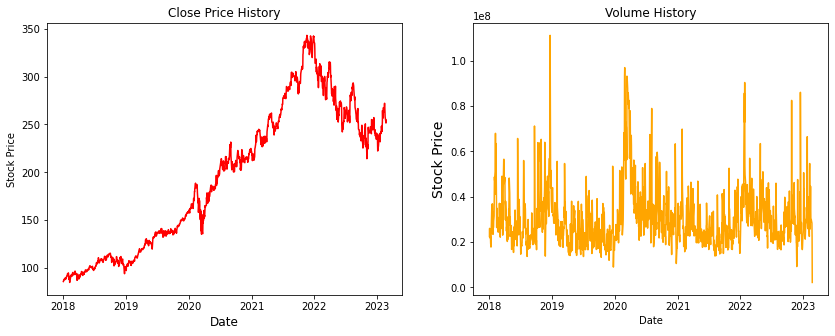

In [8]:
get_graph(MSFT_Data)

In [31]:
# This function is used to get the train data and test data
def data_preparation(df):
  data=df[["date","adj_close"]]

  data = data.rename(columns = {'date':'ds', 'adj_close':'y'})

  # Split the data into train data and test data
  #train_data = data[0:1150]
  #test_data = data[1150:]
  
  #return train_data, test_data
  return data

In [ ]:
# Define parameter grid to search over
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
}

# Initialize minimum error and best parameters
min_error = float('inf')
best_params = {}

# Loop through all parameter combinations
for params in ParameterGrid(param_grid):
    print('Testing parameters:', params)

    # Initialize Prophet model with specified hyperparameters
    model = Prophet(**params)
    model.fit(data_preparation(MSFT_Data))

    # Perform time series cross-validation
    df_cv = cross_validation(model=model, initial='1000 days', horizon='10 days', period='10 days')

    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv)

    # Calculate mean cross-validation error
    mean_cv_error = df_metrics['mse'].mean()

    # Update minimum error and best parameters if new minimum is found
    if mean_cv_error < min_error:
        min_error = mean_cv_error
        best_params = params

# Print best hyperparameters and corresponding error
print('Best parameters:', best_params)
print('Minimum cross-validation error:', min_error)


In [40]:
# We use the best parameter to fit the model
final_model = Prophet(**best_params)
final_model.fit(data_preparation(MSFT_Data))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7ldjbix2/5hdc8d1b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7ldjbix2/hjzx2i1q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12899', 'data', 'file=/tmp/tmp7ldjbix2/5hdc8d1b.json', 'init=/tmp/tmp7ldjbix2/hjzx2i1q.json', 'output', 'file=/tmp/tmp7ldjbix2/prophet_modelegndha09/prophet_model-20230228150903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:09:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:09:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds        yhat  yhat_lower  yhat_upper
0    2018-01-02   82.617751   74.099336   90.878605
1    2018-01-03   82.717682   75.329962   90.950537
2    2018-01-04   82.547800   73.694692   90.312110
3    2018-01-05   82.451125   74.403805   90.573308
4    2018-01-08   81.915603   73.330590   89.900746
...         ...         ...         ...         ...
1390 2023-05-30  221.585676  188.027143  253.588121
1391 2023-05-31  221.884841  186.749765  253.606938
1392 2023-06-01  221.475005  185.436659  255.618633
1393 2023-06-02  221.281150  185.400152  256.715311
1394 2023-06-03  220.533550  183.129889  255.174189

[1395 rows x 4 columns]


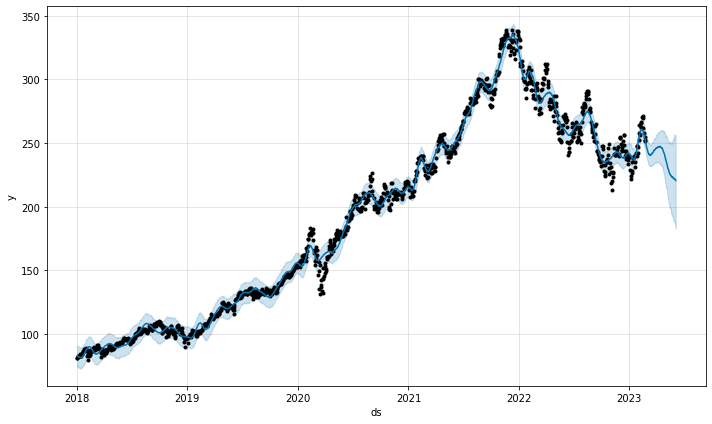

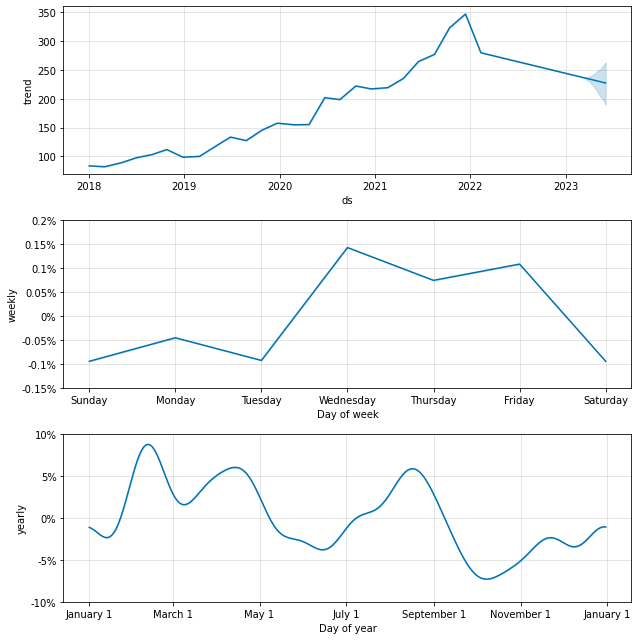

In [46]:
future = final_model.make_future_dataframe(periods=100)
validation_predict = final_model.predict(future)
print(validation_predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
fig = final_model.plot(validation_predict)
fig1 = final_model.plot_components(validation_predict)